In [1]:
# !pip install xmltodict
# %pip install torchinfo

## XML Annotation Parsing

In [2]:
import xmltodict
import os
import torch
from torchvision.transforms import functional as F
from PIL import Image

def parse_annotation(annotation_path):
    with open(annotation_path) as f:
        xml_data = xmltodict.parse(f.read())
    
    # Safely get the 'object' key
    objects = xml_data['annotation'].get('object', None)
    if objects is None:
        # If no objects, return empty boxes and labels
        return torch.empty((0, 4), dtype=torch.float32), []

    if not isinstance(objects, list):
        objects = [objects]

    boxes = []
    labels = []
    for obj in objects:
        bbox = obj['bndbox']
        boxes.append([int(bbox['xmin']), int(bbox['ymin']),
                      int(bbox['xmax']), int(bbox['ymax'])])
        labels.append(obj['name'])  # Assumes 'name' is the class label

    return torch.tensor(boxes, dtype=torch.float32), labels



## Labels To Class

In [3]:
def map_labels(labels, label_map):
    """Map string labels to integer indices."""
    return torch.tensor([label_map[label] for label in labels], dtype=torch.int64)


 ## "Object Detection Dataset Class" for PyTorch's Dataset API

In [4]:
import os
from PIL import Image

class ObjectDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, label_map, transforms=None):
        """
        Args:
            data_folder (str): Path to the folder containing images and annotations.
            label_map (dict): Dictionary mapping label names to integer indices.
            transforms (callable, optional): Transforms to apply to images.
        """
        self.data_folder = data_folder
        self.label_map = label_map
        self.transforms = transforms
        # Collect only image files (assuming .jpg) and sort
        self.image_files = sorted(
            [f for f in os.listdir(data_folder) if f.endswith('.jpg')]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image and corresponding annotation paths
        img_file = self.image_files[idx]
        img_path = os.path.join(self.data_folder, img_file)
        ann_path = os.path.join(
            self.data_folder, img_file.replace('.jpg', '.xml')
        )

        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Parse annotation
        boxes, labels = parse_annotation(ann_path)

        # Map labels to integers
        labels = map_labels(labels, self.label_map)

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels
        }

        # Apply transforms (if any)
        if self.transforms:
            image = self.transforms(image)

        return image, target


## Dataset Loading & Data Augmentation

In [5]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
# Define label map
label_map = {"Kloem": 0, "Pao": 1}  # Add more labels if needed

transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]),
])

# Initialize dataset
dataset = ObjectDetectionDataset(
    data_folder=r"C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\train",  # Replace with the path to your data folder
    label_map=label_map,
    transforms=transform
)

# Create DataLoader
data_loader = DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)



In [6]:
print(data_loader)

## Visual Image

Image Tensor Shape: torch.Size([3, 300, 300])

Target for the first image:
{'boxes': tensor([[ 31., 111., 158., 223.]]), 'labels': tensor([1])}


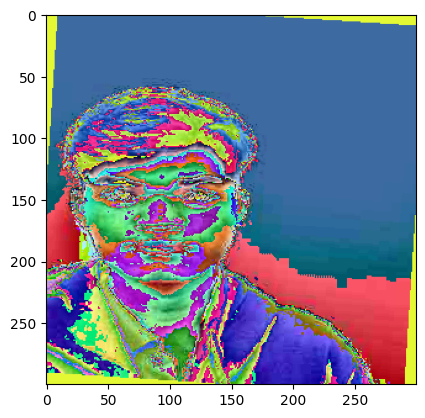

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

for images, targets in data_loader:
    # Inspect the first image and its target in the batch
    print("Image Tensor Shape:", images[0].shape)  # Example: (3, H, W)
    print("\nTarget for the first image:")
    print(targets[0])  # Contains 'boxes' and 'labels'

    # Visualize the image (if using PIL images before transformation)
    from torchvision.transforms.functional import to_pil_image
    pil_image = to_pil_image(images[0])  # Convert tensor to PIL image
    plt.imshow(pil_image)

    # Stop after the first batch for inspection
    break


## Visual Bounding Box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


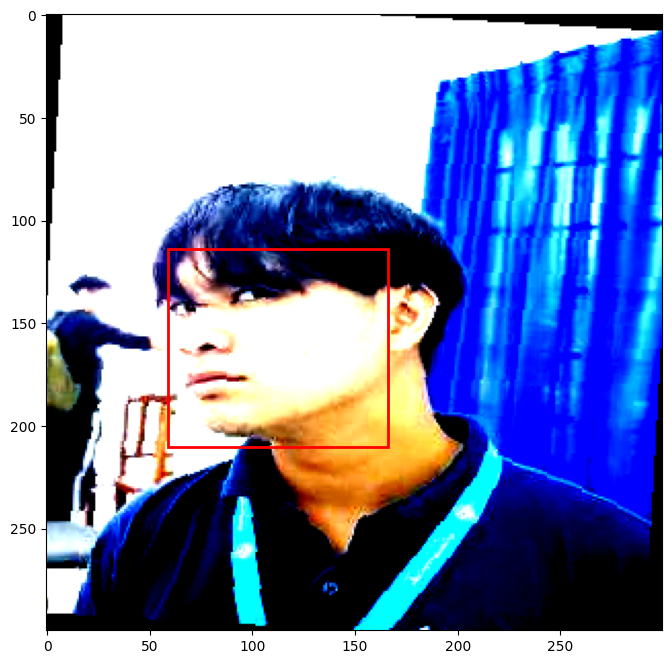

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_boxes(image, target):
    # Convert tensor to numpy array for visualization
    image = image.permute(1, 2, 0).numpy()

    # Create a figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Draw bounding boxes
    boxes = target['boxes'].numpy()
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

    plt.show()

# View one image with its bounding boxes
for images, targets in data_loader:
    visualize_image_with_boxes(images[1], targets[1])  # Visualize the first image in the batch
    break


## Image After Augmentation 

In [9]:
# Iterate through the DataLoader to fetch one batch
for images, targets in data_loader:
    print("Batch of images:")
    print(images)  # Images are PyTorch tensors

    print("\nBatch of targets (annotations):")
    print(targets)  # List of dictionaries, each containing 'boxes' and 'labels'

    # Stop after the first batch for inspection
    break


Batch of images:
(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044,

In [10]:
for batch_idx, (images, bboxes) in enumerate(data_loader):
    print(images)
    print(f"total batch {batch_idx+1}")

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

## Load Faster R_CNN Model

In [11]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn


In [ ]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model
    
num_classes = 3
model = get_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


D:\Self_Program\D_Program\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Self_Program\D_Program\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## View Model Srtucture

In [13]:
from torchinfo import summary
summary(
    model,
    input_size=(1, 3, 300, 300),  # Batch size, channels, height, width
    col_names=["input_size", "output_size", "num_params"],
    depth=3,  # Show 3 levels of the model hierarchy
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
FasterRCNN                                              [1, 3, 300, 300]          [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 300, 300]          [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 3, 800, 800]          [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 3, 800, 800]          [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 3, 800, 800]          [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 400, 400]         [1, 64, 200, 200]   

## Check Torch if Available
for run on GPU instead of CPU

In [14]:
import torch

print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")


Is CUDA available? True
CUDA version: 12.4
PyTorch version: 2.5.1+cu124
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005
)

In [16]:
import matplotlib.pyplot as plt

num_epochs = 10  
losses_per_iteration = []  
losses_per_epoch = []  

for epoch in range(num_epochs):
    model.train()
    total_loss = 0 

    for i, (images, targets) in enumerate(data_loader, start=1):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        losses_per_iteration.append(losses.item())  

        if i % 10 == 0: 
            print(f"Epoch {epoch + 1}, Iteration {i}, Loss: {losses.item():.4f}")

    avg_epoch_loss = total_loss / len(data_loader)
    losses_per_epoch.append(avg_epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")

Epoch 1, Iteration 10, Loss: 0.1874
Epoch 1, Iteration 20, Loss: 0.1110
Epoch 1/10, Average Loss: 0.2406
Epoch 2, Iteration 10, Loss: 0.0400
Epoch 2, Iteration 20, Loss: 0.0233
Epoch 2/10, Average Loss: 0.0688
Epoch 3, Iteration 10, Loss: 0.0849
Epoch 3, Iteration 20, Loss: 0.0436
Epoch 3/10, Average Loss: 0.0469
Epoch 4, Iteration 10, Loss: 0.0322
Epoch 4, Iteration 20, Loss: 0.0451
Epoch 4/10, Average Loss: 0.0318
Epoch 5, Iteration 10, Loss: 0.0196
Epoch 5, Iteration 20, Loss: 0.0542
Epoch 5/10, Average Loss: 0.0331
Epoch 6, Iteration 10, Loss: 0.0124
Epoch 6, Iteration 20, Loss: 0.0311
Epoch 6/10, Average Loss: 0.0232
Epoch 7, Iteration 10, Loss: 0.0225
Epoch 7, Iteration 20, Loss: 0.0179
Epoch 7/10, Average Loss: 0.0245
Epoch 8, Iteration 10, Loss: 0.0215
Epoch 8, Iteration 20, Loss: 0.0155
Epoch 8/10, Average Loss: 0.0194
Epoch 9, Iteration 10, Loss: 0.0220
Epoch 9, Iteration 20, Loss: 0.0100
Epoch 9/10, Average Loss: 0.0176
Epoch 10, Iteration 10, Loss: 0.0087
Epoch 10, Iteratio

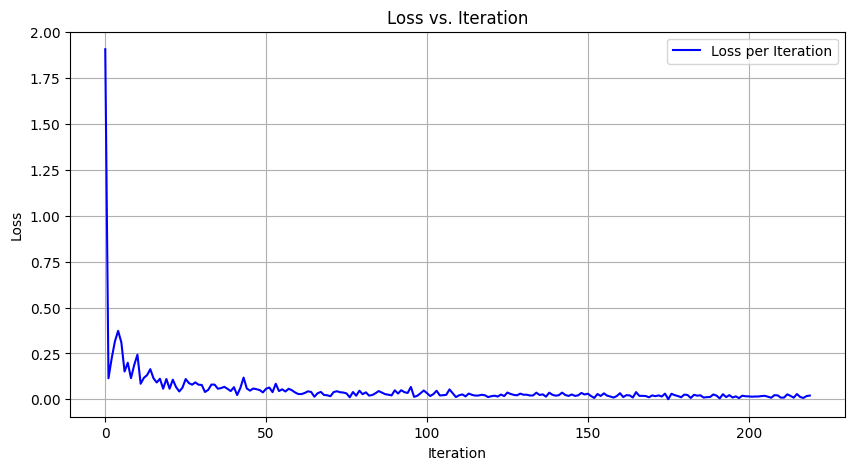

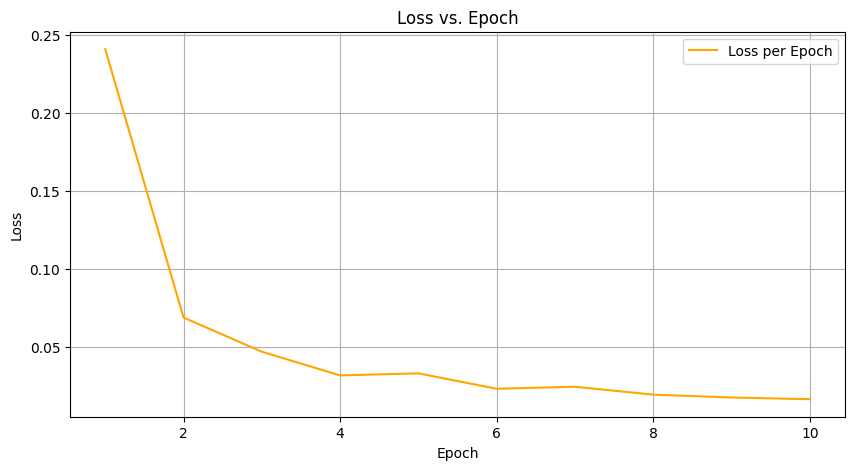

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(losses_per_iteration, label="Loss per Iteration", color='blue')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs. Iteration")
plt.legend()
plt.grid()
plt.show()

# Plotting Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses_per_epoch, label="Loss per Epoch", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    for images, targets in data_loader:
        images = [img.to(device) for img in images]

        # Get predictions
        predictions = model(images)

        # Example: View predictions for the first image
        print("Predictions for the first image:")
        print(predictions[0])  # Contains 'boxes', 'labels', 'scores'

        # Break after inspecting one batch
        break


Predictions for the first image:
{'boxes': tensor([[ 72.5095, 137.0595, 194.9610, 249.0251]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}


In [24]:
torch.save(model.state_dict(), "fasterrcnn_model_with_face2.pth")

In [25]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the model and modify for your use case
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)  # Pretrained=False for loading trained weights
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model

num_classes = 3  # Background + fire + smoke
model = get_model(num_classes)

# Load weights
model.load_state_dict(torch.load("fasterrcnn_model_with_face2.pth"))
model.eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


C:\Users\sedth\AppData\Local\Temp\ipykernel_3912\21376165.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fasterrcnn_model_with_face2.

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [33]:
from PIL import Image
import torchvision.transforms as T
transform2 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((250, 250)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transform2  # Convert image to tensor
    return transform(image)

# Example image path
image_path = r"C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\train\20250109_165204_001_saved_jpg.rf.dbd9a9865e5b70413d3fb0ba0d91aecd.jpg"
image = preprocess_image(image_path).to(device)


In [34]:
# Perform inference
with torch.no_grad():
    predictions = model([image])  # Add image as a batch

# Extract predictions
predicted_boxes = predictions[0]['boxes'].cpu().numpy()
predicted_labels = predictions[0]['labels'].cpu().numpy()
predicted_scores = predictions[0]['scores'].cpu().numpy()


In [35]:
# Set a confidence threshold
confidence_threshold = 0.75

filtered_boxes = []
filtered_labels = []
for box, label, score in zip(predicted_boxes, predicted_labels, predicted_scores):
    if score >= confidence_threshold:
        filtered_boxes.append(box)
        filtered_labels.append(label)

print("Filtered Boxes:", filtered_boxes)
print("Filtered Labels:", filtered_labels)


Filtered Boxes: []
Filtered Labels: []


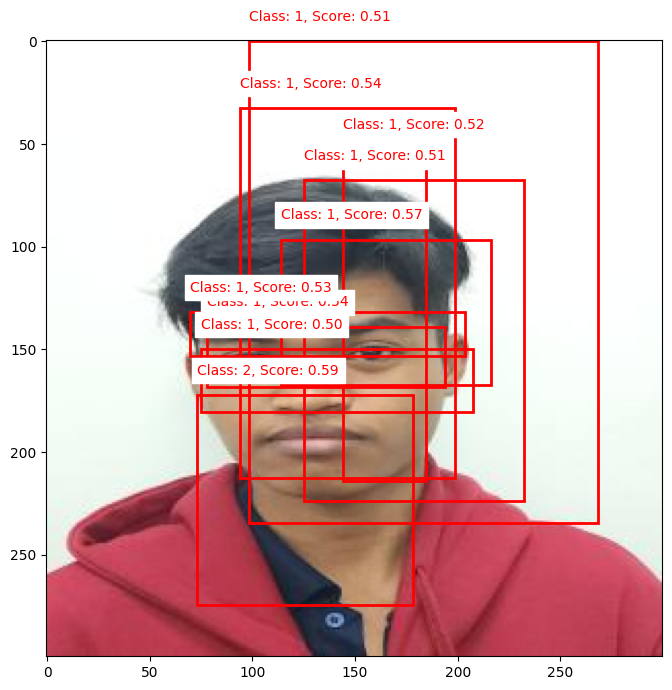

In [42]:
import torch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the function to load and preprocess the image
def preprocess_image(image_path, device):
    image = Image.open(image_path).convert("RGB")  # Load and convert to RGB
    image_tensor = F.to_tensor(image).to(device)  # Convert to tensor and move to device
    return image, [image_tensor]
def visualize_prediction(image, predictions, threshold=0.5):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    # Loop through predictions and filter by score
    for box, score, label in zip(predictions["boxes"], predictions["scores"], predictions["labels"]):
        if score > threshold:
            # Draw the bounding box
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

            # Add label and score
            text = f"Class: {label}, Score: {score:.2f}"
            ax.text(xmin, ymin - 10, text, color="red", fontsize=10, backgroundcolor="white")
    
    # plt.axis("off")
    plt.show()

# Define the prediction function
def predict_image(model, image_path, device, score_threshold=0.50):
    # Preprocess the image
    original_image, processed_image = preprocess_image(image_path, device)

    # Make predictions
    with torch.no_grad():
        predictions = model(processed_image)

    # Convert predictions to CPU for visualization
    predictions = {k: v.to("cpu") for k, v in predictions[0].items()}

    # Visualize predictions
    visualize_prediction(original_image, predictions, threshold=score_threshold)

predict_image(model, image_path, device)


In [43]:
from torch.utils.data import DataLoader

test = r'C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\test'
# Assuming you have a dataset class implemented
label_map = {"Kloem": 0, "Pao": 1}
test_dataset = ObjectDetectionDataset(data_folder=test, label_map=label_map, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [44]:
from torchvision.ops import box_iou

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    iou_threshold = 0.2  # Define IoU threshold for a positive match
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for images, targets in test_loader:
            # Move images and targets to the appropriate device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions from the model
            outputs = model(images)

            for target, output in zip(targets, outputs):
                # Ground truth boxes and labels
                gt_boxes = target['boxes']
                gt_labels = target['labels']

                # Predicted boxes, labels, and scores
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                pred_scores = output['scores']

                # Filter predictions based on confidence threshold
                keep = pred_scores >= 0.2  # Adjust confidence threshold if needed
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                # Store predictions and ground truths
                all_predictions.append((pred_boxes, pred_labels))
                all_ground_truths.append((gt_boxes, gt_labels))

    # Compute evaluation metrics (e.g., mAP)
    calculate_map(all_predictions, all_ground_truths, iou_threshold)

def calculate_map(predictions, ground_truths, iou_threshold):
    """
    Compute Mean Average Precision (mAP) for the dataset.
    """
    correct_detections = 0
    total_detections = 0
    total_ground_truths = 0

    for pred, gt in zip(predictions, ground_truths):
        pred_boxes, pred_labels = pred
        gt_boxes, gt_labels = gt

        total_ground_truths += len(gt_boxes)
        total_detections += len(pred_boxes)

        if len(gt_boxes) == 0 or len(pred_boxes) == 0:
            continue

        iou = box_iou(pred_boxes, gt_boxes)  # Compute IoU between all predictions and ground truths
        for i in range(len(pred_boxes)):
            max_iou, max_idx = iou[i].max(0)
            if max_iou >= iou_threshold:
                correct_detections += 1
                iou[:, max_idx] = 0  # Ensure the ground truth is not double-counted

    precision = correct_detections / total_detections if total_detections > 0 else 0
    recall = correct_detections / total_ground_truths if total_ground_truths > 0 else 0

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


In [45]:
evaluate_model(model, test_loader, device)

Precision: 0.0096, Recall: 0.9583
